In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.spatial import distance as dist
from skimage.measure import label

In [2]:
def plot_img(img, figsize=(10,10), cmap='gray', no_axis=True):
    
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    
    if no_axis:
        plt.axis('off')
        
    plt.show()

# Normalization

In [3]:
def get_bounding_contours(img, debug=True):
    """
    Find the bounding boxes for the image to color
    """
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blured = cv.medianBlur(img_gray, 3)        
    th = cv.adaptiveThreshold(blured, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv.THRESH_BINARY, 9, 3)
    erode = cv.erode(th, np.ones((3,3)), iterations = 1)  
        
    contours, hierarchy = cv.findContours(255-erode, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    v, c = np.unique(hierarchy[0][:, 3], return_counts=True)
    hierarchy_counts = sorted(zip(c, v))
    
    bounding_contours = [i[1] for i in hierarchy_counts if i[0] > 50]
    
    final_contours = []

    for c in bounding_contours:
        peri = cv.arcLength(contours[c], True)
        if peri > 100:
            approx = cv.approxPolyDP(contours[c], 0.02 * peri, True)
            if len(approx) == 4:
                final_contours.append(approx)
            else:
                hull = cv.convexHull(approx)
                peri = cv.arcLength(hull, True)
                approx = cv.approxPolyDP(hull, 0.02 * peri, True)
                if len(approx) == 4:
                    final_contours.append(approx)
                    
    if debug:
        
        plot_img(img)
        plot_img(img_gray)
        plot_img(blured)
        plot_img(erode)
        plot_img(th)
        
        img_c = img.copy()
        cv.drawContours(img_c, final_contours, -1, (0,255,0), 10)
        plot_img(img_c)
        
    return final_contours


def normalize_drawing(img, bounding_box):
    """
    Normalize the image with the found bounding box
    """
    
    src = bounding_box.astype('float32')

    h, w = img.shape[:2]
    
    xSorted = src[:, 0, :][np.argsort(src[:, 0, 0]), :]
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    src = np.float32([tl, tr, br, bl])
    
    new_w = int(np.sqrt((tr[0] - tl[0])**2 + (tr[1] - tl[1])**2))
    new_h = int(np.sqrt((br[0] - tr[0])**2 + (br[1] - tr[1])**2))
    
    dst = np.float32([(0, 0), (new_w, 0), (new_w, new_h), (0, new_h)])
    
    M = cv.getPerspectiveTransform(src, dst)
    
    warped = cv.warpPerspective(img, M, (new_w, new_h), flags=cv.INTER_LINEAR)
    box = np.int32([0, h, tr[0], w])

    return warped, box

# Template-color mapping extraction

In [4]:
def add_contours(img, squares):
    """
    Find contours missed by contourfinding
    """
    squares = np.array(squares)
    x_coord = int(np.mean(squares[:, 0]))
    h = int(np.max(squares[:, -1]))
    w = int(np.max(squares[:, -2]))
    y_min = int(np.min(squares[:,1]))
    y_max = int(np.max(squares[:,1]))
    approx_dist_betw_centers = int(np.median(squares[:-1, 1] - squares[1:, 1]))

    i = 1
    while True:
        diff = -squares[i, 1] + squares[i-1, 1]
        if diff > approx_dist_betw_centers * 1.3:
            number_of_lost_squares = int(diff/approx_dist_betw_centers/1.3)
            add_arr = []
            for j in range(number_of_lost_squares):
                add_arr.append([x_coord, squares[i-1, 1] - (j+1)*approx_dist_betw_centers, h, w])
            squares = np.vstack((squares[:i, :], np.array(add_arr), squares[i:, :]))
        i+=1
        if i == squares.shape[0] - 1:
            break

    if y_min > h:
        cur_coord = y_min
        while cur_coord + int(h/2) > h*0.75:
            cur_coord = cur_coord - h
            if np.min(img[cur_coord + int(h/2), x_coord + int(w/2), :]) < 230:
                squares = np.vstack((squares, np.array([x_coord, cur_coord, h, w])))

    cur_coord = y_max
    while cur_coord + approx_dist_betw_centers + int(h/2) < img.shape[0]:
        cur_coord = cur_coord + approx_dist_betw_centers
        if np.min(img[cur_coord + int(h/2), x_coord + int(w/2), :]) < 230:
            squares = np.vstack((squares, np.array([x_coord, cur_coord, h, w])))


    return squares

def get_colours(img, colored_blobs, blur, block_size, C):
    """
    Get the color of the blob
    """
    res = []
    for blob in colored_blobs:
        x, y, w, h = blob
        colour = img[y + int(w/2), x + int(h/2), :]
        piece = img[y:y+w, x+h:, :]
        res.append([piece, colour])

    return res

def get_colours_map(img, bounds, blur=3, block_size=13, C=7, areas_th=280):
    """
    Get the template(number)-color mapping
    """
    img_grayscale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    img_colours = img_grayscale[bounds[0] : bounds[1], bounds[2] : bounds[3]]
    blured = cv.medianBlur(img_colours, blur)
    th = cv.adaptiveThreshold(blured, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv.THRESH_BINARY, block_size, C)
    
    contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = np.array(contours[1:]), np.array(hierarchy[0][1:])

    areas = np.array([cv.contourArea(cnt) for  cnt in contours])

    contours, hierarchy = contours[areas>areas_th], hierarchy[areas>areas_th]
    contours, hierarchy = contours[hierarchy[:, -1] == 0], hierarchy[hierarchy[:, -1] == 0]

    cx, cy = [], []
    squares = []
    img_cnt = img[bounds[0] : bounds[1], bounds[2] : bounds[3], :].copy()
    for contour in contours:
        x,y,w,h = cv.boundingRect(contour)
        squares.append([x,y,w,h])
    
    squares = add_contours(img_cnt, squares)
    colors_map = get_colours(img_cnt, squares, blur, block_size, C)

    return colors_map

def find_templates(image, bounds, debug=True):
    """
    Extract the mapping
    """

    res = get_colours_map(image, bounds)
    
    res = [[crop_nmb(cv.cvtColor(i[0], cv.COLOR_RGB2GRAY)), i[1]] for i in res][::-1]
    
    if debug:
        for elm in res:
            plot_img(elm[0], (3,3))
    
    return res

# Find regions

In [5]:
def find_contours(img, debug):
    """
    Find all contours on the picture
    """

    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    th = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv.THRESH_BINARY, 41, 7)
    
    contours, hierarchy = cv.findContours(255-th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    if debug:
        img_c = img.copy()
        
        plot_img(img)
        plot_img(img_gray)
        plot_img(th)
        
        for c in np.array(contours):
            cv.drawContours(img_c, [c], -1,
                            [int(i) for i in np.random.randint(0, 255, size=3)], -1)
        plot_img(img_c)
        
    return contours, hierarchy

def arange_conotours_by_hierarchy(contours, hierarchy, img):
    """
    Sort the contours by their hierarchy
    Start with the most nested and end with the outer ones
    """
    contours_by_hierarchy = [np.where(hierarchy[0][:, 2] == -1)[0]]
    img_c = img.copy()    

    while True:
        cur = np.where(np.isin(hierarchy[0][:, 2], contours_by_hierarchy[-1]))[0]
        if cur.shape[0] != 0:
            contours_by_hierarchy.append(cur)
        else:
            break            

    return np.hstack(contours_by_hierarchy)

# Get templates for numbers and find matches

In [6]:
def crop_nmb(number, pad=0):
    """
    Crop the template with the tight box
    """
    number = number
    rows = (number.min(axis=1) < 100)
    rows_start, rows_end = np.argmax(rows), np.argmax(rows[::-1])
    cropped = number[rows_start: len(rows) - rows_end]
    
    cols = (cropped.min(axis=0) < 100)
    cols_start, cols_end = np.argmax(cols), np.argmax(cols[::-1])
    
    
    cropped = number[max(rows_start - pad, 0): len(rows) - rows_end + pad,
                     max(cols_start-pad, 0): len(cols) - cols_end + pad]
    
    return cropped

def get_local_centers(corr, th):
    """
    Get local minima of templates correralation
    """
    lbl, n = label(corr >= th, connectivity=2, return_num=True)
    return np.int16([np.round(np.mean(np.argwhere(lbl == i), axis=0)) for i in range(1, n + 1)])

def find_numbers(img, templates, debug=False):
    """
    Get template(numbers) matches
    """
    img_c = img.copy()
    img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    matches = []
    
    thresholds = [0.8] * max(len(templates), 10)
    
    thresholds[0] = 0.85
    thresholds[2] = 0.77
    thresholds[3] = 0.77
    thresholds[4] = 0.7
    thresholds[6] = 0.85
    thresholds[7] = 0.75
    
    l = len(templates)
    order_to_ten = np.array([10, 2, 9, 3, 6, 5, 8, 4, 7, 1])
    order = np.array([10 * i + order_to_ten for i in range(l // 10 + 1)[::-1]]).flatten()
    order = [i for i in order if i <= l]

    for i in order:
        template = templates[i-1]
        w, h = template.shape[::-1]

        res = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)
        
        points = get_local_centers(res, thresholds[i-1])
        if points.shape[0] > 0:
            points = points[:, ::-1]
        
            centers = np.array(points) + np.array([w // 2, h // 2])
            centers = np.insert(centers, 2, i, axis=1)
            matches.append(centers)

            if debug:
                img2 = img_c.copy()
                for pt in points:
                    pt = tuple(pt)
                    cv.rectangle(img2, (pt[0]-5, pt[1]-5), (pt[0] + w + 5, pt[1] + h + 5), (255,0,0), 1)

                plot_img(img2)
            
    return np.vstack(matches)

# Map numbers to contours

In [7]:
def link_contours_with_numbers(contours, contours_by_hierarchy, numbers_coords, img):
    """
    Map each contour to a number and each template match to a contour
    """
    
    numbers_coords = np.insert(numbers_coords, 3, -1, axis=1)
    contour_numbers = {}
    
    img_c = img.copy()
    
    for contour in contours_by_hierarchy:

        mask = np.zeros_like(img)
                
        cv.drawContours(mask, contours, contour, color=255, thickness=-1)

        pts = np.where(mask == 255)
        blackness = img[pts[0], pts[1]].mean()
        if (blackness < 150) or (cv.contourArea(contours[contour], False) < 100):
            continue

        found = False
        for i, number in enumerate(numbers_coords):
            if (number[3] == -1) and (cv.pointPolygonTest(contours[contour], tuple(number[:2]), True) >= -5):
                
                    contour_numbers[contour] = number[2]
                    numbers_coords[i][3] = contour
                    
                    found = True
                    break

        if not found:
            contour_numbers[contour] = -1
            
    return contour_numbers, numbers_coords

# Image inpainting

In [8]:
def inpaint_image(img, contours, contour_numbers, colors):
    """
    Color the contours according to the mapping
    """
    img_c = img.copy()

    for i, c in enumerate(np.array(contours)):
        if i in contour_numbers and contour_numbers[i] != -1:
            color = colors[contour_numbers[i]-1]
            color = color.tolist()
            
            cv.drawContours(img_c, [c], -1, color, -1)
            cv.drawContours(img_c, [c], -1, [0, 0, 0], 2)
            
        else:
            cv.drawContours(img_c, [c], -1, [255, 255, 255], -1)
            cv.drawContours(img_c, [c], -1, [0, 0, 0], 2)
            
    return img_c

def color_by_numbers(image, debug):
    """
    The whole color by numbers procedure
    """
    
    bound = get_bounding_contours(image, debug)
    img_normalazed, box = normalize_drawing(image, bound[0])
    
    contours, hierarchy = find_contours(img_normalazed, debug)
    contours_by_hierarchy = arange_conotours_by_hierarchy(contours, hierarchy, img_normalazed)
    
    templates = find_templates(image, box, debug)
    
    numbers_coords = find_numbers(img_normalazed, [i[0] for i in templates], debug)
    
    contour_numbers, numbers_coords = \
        link_contours_with_numbers(contours, contours_by_hierarchy,
                                   numbers_coords, cv.cvtColor(img_normalazed, cv.COLOR_RGB2GRAY))
    
    painted_image = inpaint_image(img_normalazed, contours, contour_numbers, [i[1] for i in templates])
    
    return painted_image

In [9]:
images = [cv.cvtColor(cv.imread('images/' + f), cv.COLOR_BGR2RGB) for f in sorted(os.listdir('images/'))]

# Input images

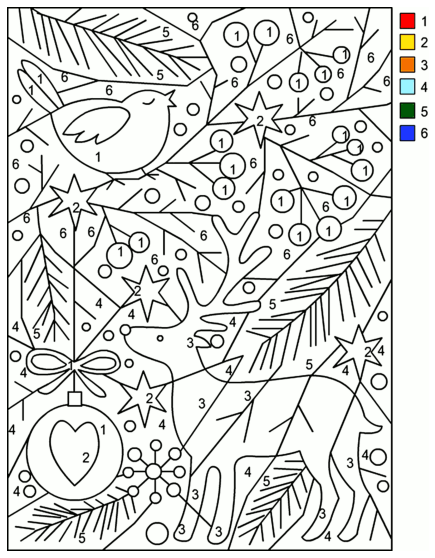

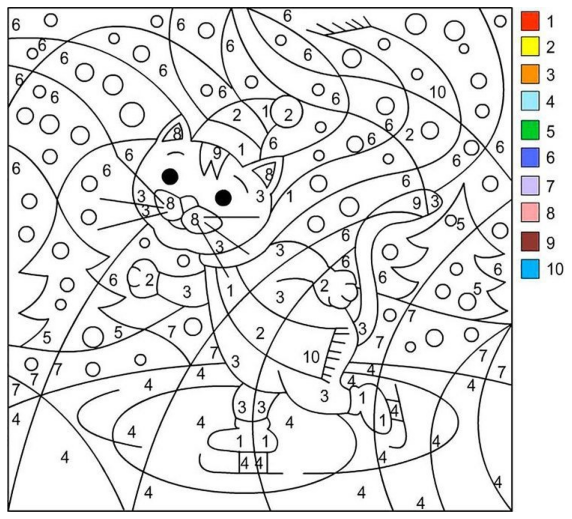

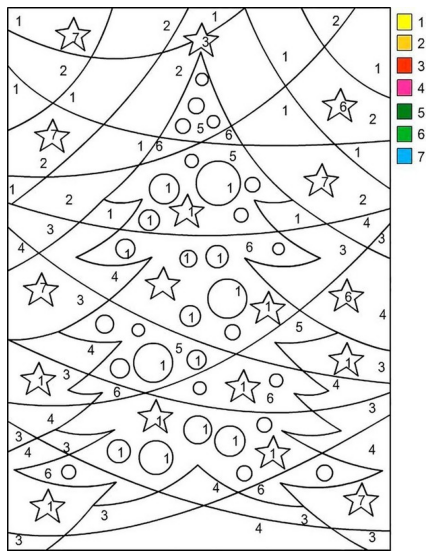

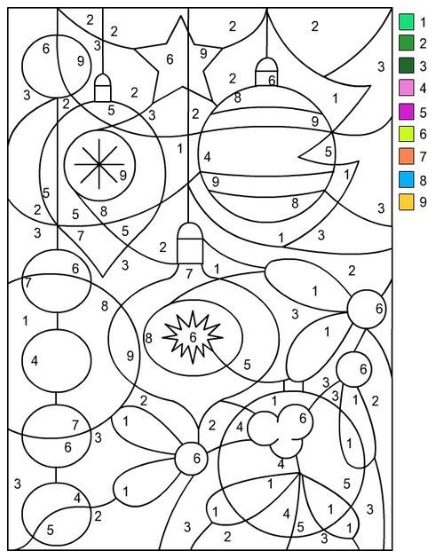

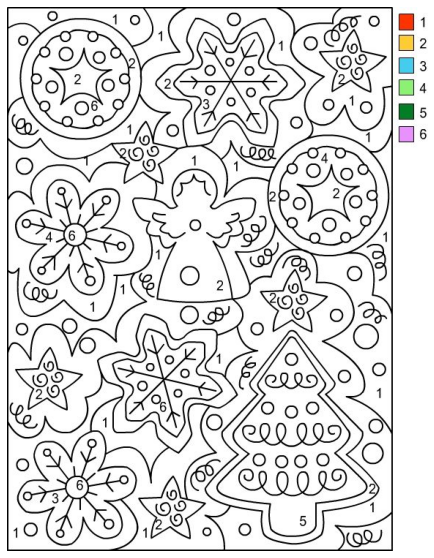

In [10]:
for img in images:
    plot_img(img)

# Output images

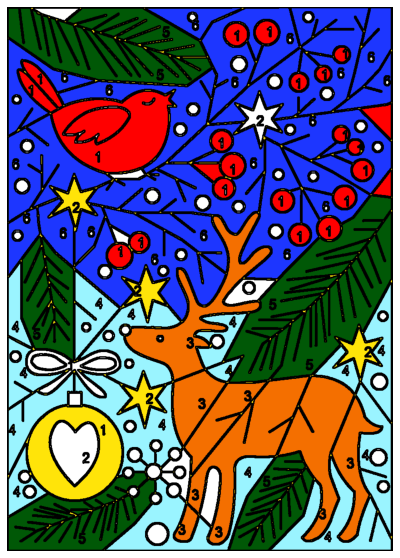

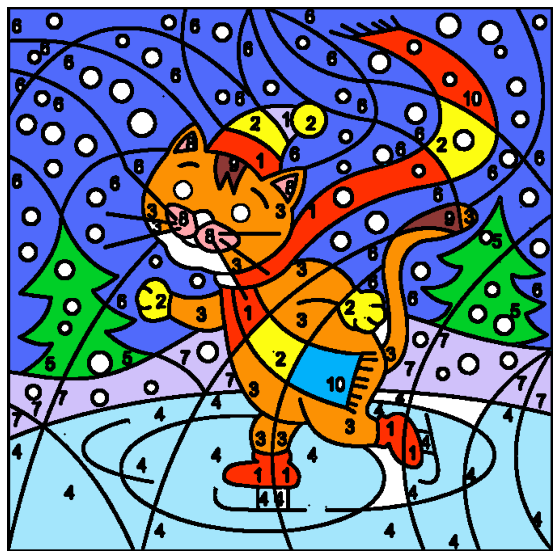

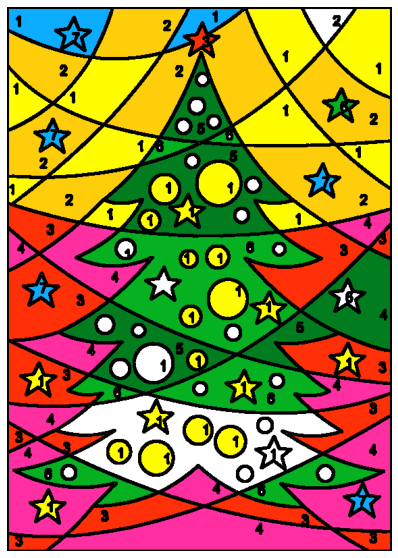

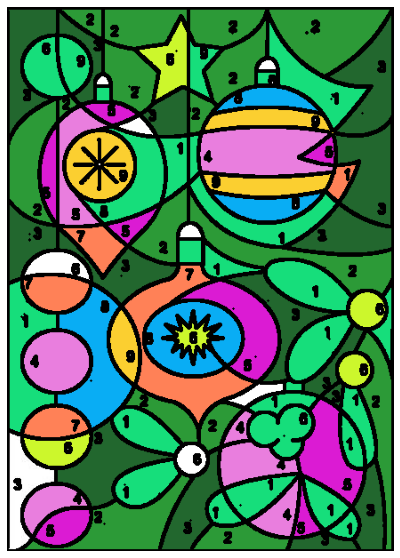

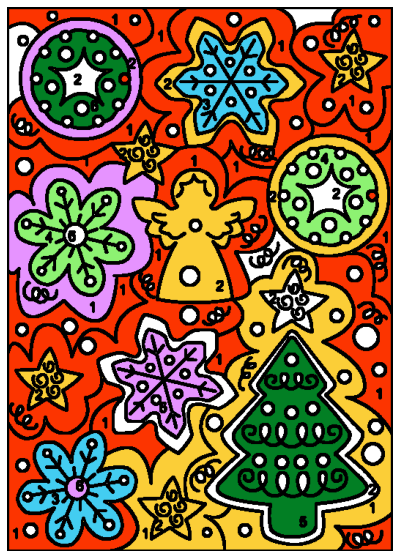

In [11]:
for img in images:
        plot_img(color_by_numbers(img, False))

# Output with intermediate steps

In [1]:
# for img in images:
#         plot_img(color_by_numbers(img, True))